Step 1. Ensure that you have the dataset file named `transactions.csv` in the current directory.

The dataset is a subset of https://www.kaggle.com/ealaxi/paysim1/version/2 which was originally generated as part of the following research:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

Use the empty cell to test the exercises. If you modify the original df, you can rerun the cell containing exercise_0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [151]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [152]:
df = pd.read_csv('transactions.csv')
df = df.rename(columns={'oldbalanceOrg' :'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest' : 'newBalanceDest'})
print(df.head(20))

    step      type     amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0      1   PAYMENT    9839.64  C1231006815       170136.00       160296.36   
1      1   PAYMENT    1864.28  C1666544295        21249.00        19384.72   
2      1  TRANSFER     181.00  C1305486145          181.00            0.00   
3      1  CASH_OUT     181.00   C840083671          181.00            0.00   
4      1   PAYMENT   11668.14  C2048537720        41554.00        29885.86   
5      1   PAYMENT    7817.71    C90045638        53860.00        46042.29   
6      1   PAYMENT    7107.77   C154988899       183195.00       176087.23   
7      1   PAYMENT    7861.64  C1912850431       176087.23       168225.59   
8      1   PAYMENT    4024.36  C1265012928         2671.00            0.00   
9      1     DEBIT    5337.77   C712410124        41720.00        36382.23   
10     1     DEBIT    9644.94  C1900366749         4465.00            0.00   
11     1   PAYMENT    3099.97   C249177573        20771.00      

In [153]:
df.isnull().values.any()

False

In [154]:
print('\n The types of fraudulent transaction are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]

dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\n The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer)))

print('\n The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout)))


 The types of fraudulent transaction are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 72

 The number of fraudulent CASH_OUTs = 75


In [155]:
CountisFlaggedFraud = df.loc[(df.isFlaggedFraud == 1)]

CountisFlaggedFraudWithTransfer = df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]

print(len(CountisFlaggedFraud))
print(len(CountisFlaggedFraudWithTransfer))
print(df.shape)
print(CountisFlaggedFraudWithTransfer)

print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))


dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\n The minimum amount transacted when isFlaggedFraud is set ={}'.format(dfFlagged.amount.min()))

print('\n The max amount transacted when isFlaggedFraud is set ={}'.format(dfFlagged.amount.max()))

print('\nThe max amount is TRANSFERED when isFlaggedFraud is NOT set ={}'.format(dfNotFlagged.amount.max()))

0
0
(200000, 11)
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldBalanceOrig, newBalanceOrig, nameDest, oldBalanceDest, newBalanceDest, isFraud, isFlaggedFraud]
Index: []

The type of transactions in which isFlaggedFraud is set: []

 The minimum amount transacted when isFlaggedFraud is set =nan

 The max amount transacted when isFlaggedFraud is set =nan

The max amount is TRANSFERED when isFlaggedFraud is NOT set =10000000.0


In [156]:
#print('The no. of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0 is : {}'.format(len(dfTransfer.loc[(dfTransfer.isFlaggedFruad == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)])))
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: {}'.format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) 


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 96


In [157]:
print('\n Min, Max of OldBalanceOrig for isFlaggedFraud = 1 Transfers are : {}'.format([round(dfFlagged.oldBalanceOrig.min(), 2), round(dfFlagged.oldBalanceOrig.fillna(0).max(), 2)]))

print('\n Min, Max of oldBalanceOrig of isFlaggedFraud = 0 Transfers where oldBalanceOrig = newBalanceOrig : {}'.format([dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) 
                                                                                                                                       & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig)].oldBalanceOrig.min(),
                                                                                                                                       dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) 
                                                                                                                                       & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig)].oldBalanceOrig.max()]))


 Min, Max of OldBalanceOrig for isFlaggedFraud = 1 Transfers are : [nan, nan]

 Min, Max of oldBalanceOrig of isFlaggedFraud = 0 Transfers where oldBalanceOrig = newBalanceOrig : [0.0, 575667.54]


In [158]:
print('\nHave Originators of transactions flagged as fraud transacted more than once? {}'
      .format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig,dfNotFlagged.nameDest]))).any()))


print('\nHave destinations for transactions flagged as fraud initiated other transactions? {}'
      .format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))


print('\nHow many destination accounts of transactions as flagged as fraud have been destination accounts more than once?: {}'
     .format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))


Have Originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions as flagged as fraud have been destination accounts more than once?: 0


In [159]:
#Checking are there any merchant accounts for Cash_in transaction

print('\nAre there any merchants among originators accounts for CASH_IN transactions? {}'
     .format((df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originators accounts for CASH_IN transactions? False


In [160]:
print('\nAre there any merchants among destination accounts for CASH_OUT transactions? {}'.format((df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))



Are there any merchants among destination accounts for CASH_OUT transactions? False


In [161]:
#let's check if there are any merchants among originators accounts?

print('\nAre there are any merchants accounts among any originator accounts?\n{}'
     .format(df.nameOrig.str.contains('M').any()))

# Let's check are there any transactions having merchants among destination accounts other than the PAYMENT type


print('\nAre there any transactions having merchants among destination accounts other than the PAYMENT type?\n{}'
      .format((df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there are any merchants accounts among any originator accounts?
False

Are there any transactions having merchants among destination accounts other than the PAYMENT type?
False


In [162]:
print('\nWithin fraudlent transactions, are there destinations for TRANSFERs that are also originators for CASH_OUTs?\n{}'
     .format((dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))

dfNotFraud = df.loc[df.isFraud == 0]


Within fraudlent transactions, are there destinations for TRANSFERs that are also originators for CASH_OUTs?
False


In [163]:
print('\nFraudlent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:\n\n{}'
     .format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))



Fraudlent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldBalanceOrig, newBalanceOrig, nameDest, oldBalanceDest, newBalanceDest, isFraud, isFlaggedFraud]
Index: []


In [164]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

In [165]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.3945578231292517

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.004580593192829749


In [166]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), 
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [167]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), 
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [168]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [169]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, 
             hue = hue, jitter = 0.4, marker = '.', 
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), 
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


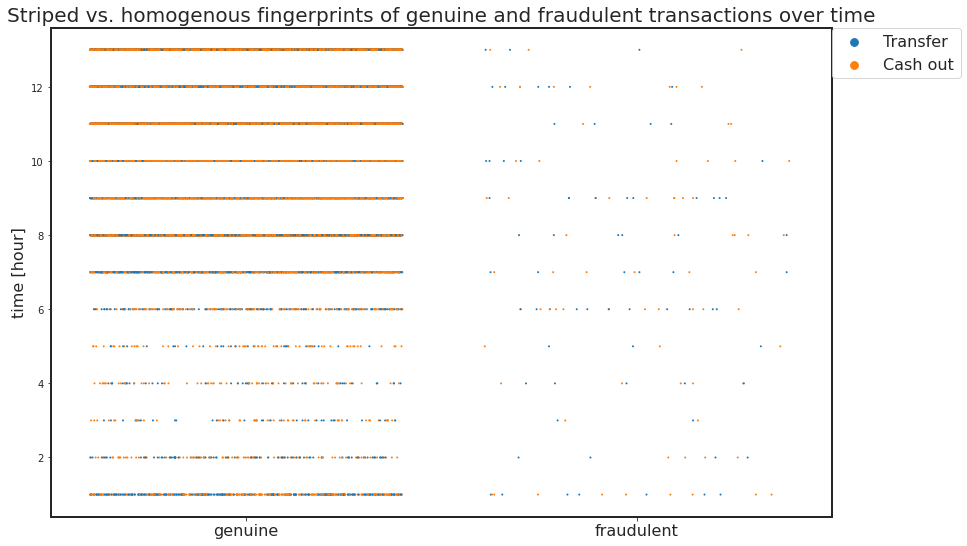

In [170]:
ax =  plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20);

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


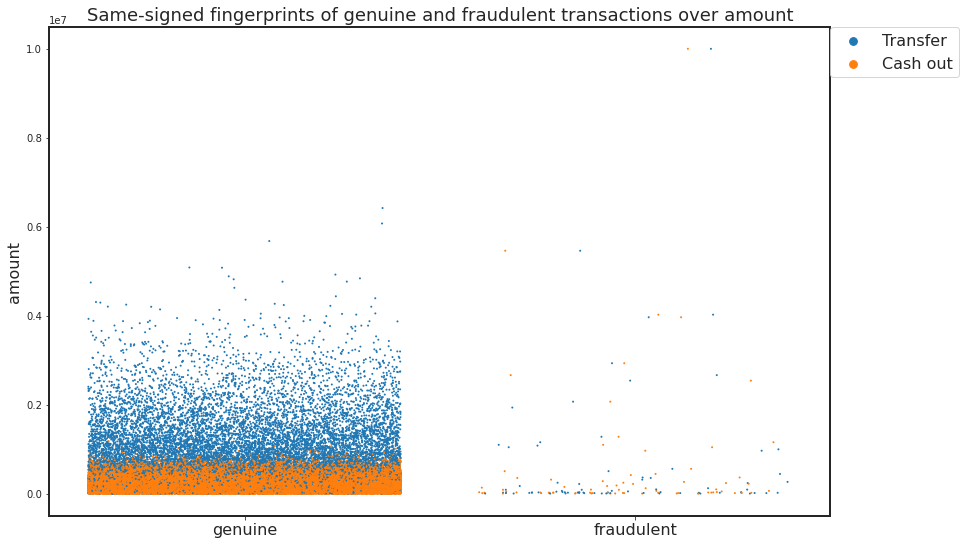

In [171]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

# Assistant
This error occurs because the function `plotStrip` has not been defined or imported in the code. The code is trying to call the `plotStrip` function, but since it is not defined, a `NameError` is raised.

Would you like me to provide the corrected code?

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


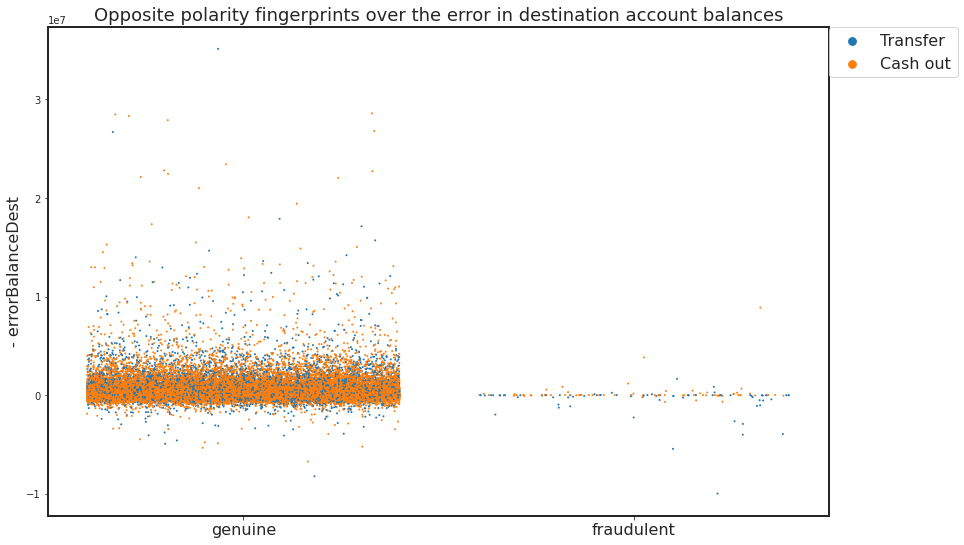

In [173]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

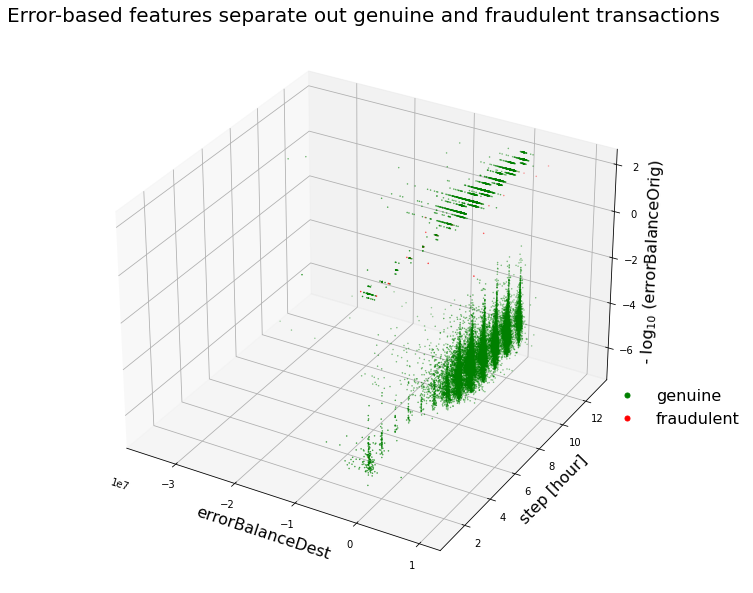

In [174]:
#long computatuiton time (copied code)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

In [175]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.0017641975901300946


In [176]:
#Split the data into training and test sets in a 80:20 ratio

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [177]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9299870861866881


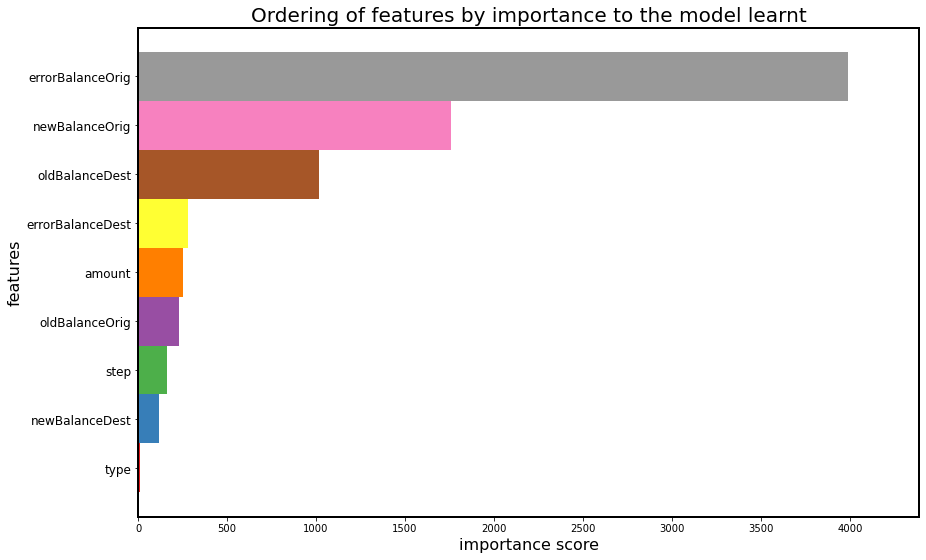

In [178]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [179]:
#long computation
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

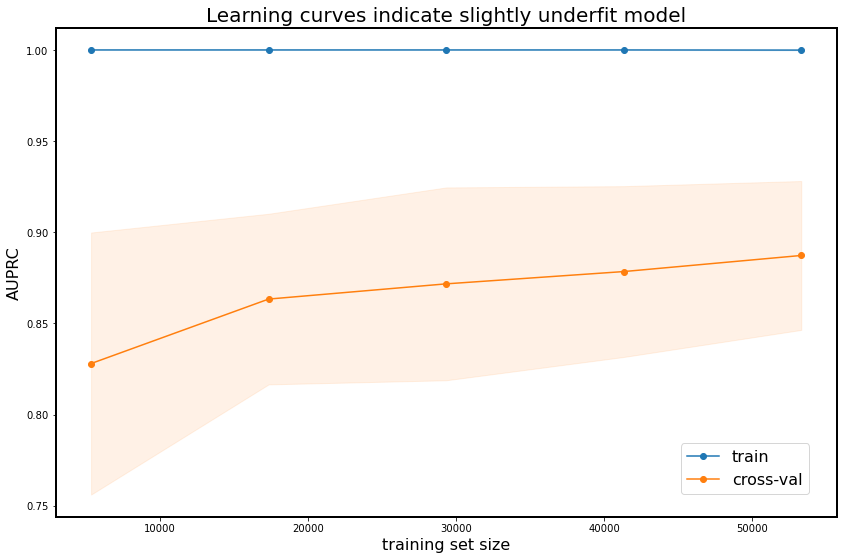

In [180]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

All done!

Your work will be instrumental for our team's continued success.